## 基于PyTorch实现图像去模糊任务

## 任务描述
- 相机的抖动、快速运动的物体都会导致拍摄出模糊的图像，景深变化也会使图像进一步模糊。
- 对于传统方法来说，要想估计出每个像素点对应的 “blur kernel” 几乎是不可行的。因此，传统方法常常需要对模糊源作出假设，将 “blur kernel” 参数化。显然，这类方法不足以解决实际中各种复杂因素引起的图像模糊。
- 卷积神经网络能够从图像中提取出复杂的特征，从而使得模型能够适应各种场景。  
- 本教程以 CVPR2017 的 《Deep Multi-scale Convolutional Neural Network for Dynamic Scene Deblurring》 为例，来完成图像去模糊的任务。
### 方法概述
- 利用pytorch深度学习工具实现一个端到端的图像去模糊模型，通过参数设置、加载数据、构建模型、训练模型和测试用例依次实现一个图像去模糊工具，在训练和预处理过程中通过可视化监督训练过程。 
- 模型采用了残差形式的CNN，输入和输出都采用高斯金字塔（Gaussian pyramid）的形式。
- 整个网络结构由三个相似的CNN构成，分别对应输入金字塔中的每一层。网络最前面是分辨率最低的子网络（coarest level network），在这个子网络最后，是“upconvolution layer”，将重建的低分辨率图像放大为高分辨率图像，然后和高一层的子网络的输入连接在一起，作为上层网络的输入。

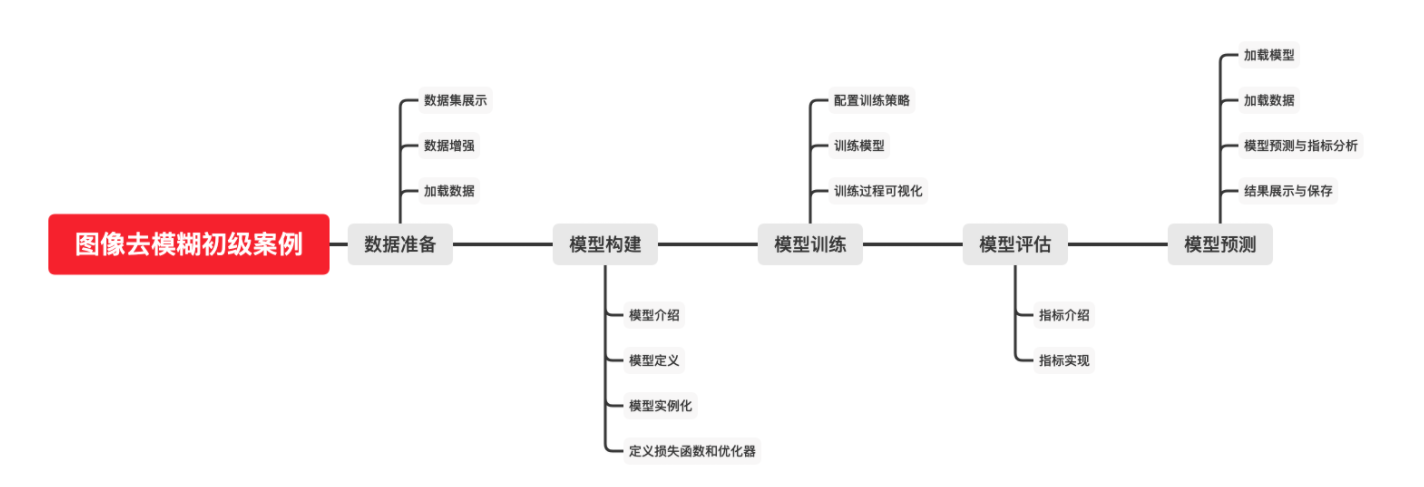

In [1]:
%config Completer.use_jedi = False

ValueError: magics not found

In [ ]:
# !pip install ipywidgets -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
import torch

import numpy as np

import os
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from tensorboardX import SummaryWriter
from torchsummary import summary
from torch.optim import lr_scheduler
from torch.utils import data
from torchvision import transforms
from tqdm.notebook import tqdm


## 参数设置

In [ ]:
class Config():
    def __init__(self,name="Configs"):
        # train set
        self.data_dir = 'datasets/train' # 训练集目录
        self.patch_size = 256  # 输入模型的patch的尺寸
        self.batch_size= 2 #16 # 训练时每个batch中的样本个数
        self.n_threads = 2 # 用于加载数据的线程数
        
        # test set
        self.test_data_dir = 'datasets/test' # 测试集目录
        self.test_batch_size=1 # 测试时的 batch_size
        
        # model
        self.multi = True # 模型采用多尺度方法True
        self.skip = True # 模型采用滑动连接方法
        self.n_resblocks = 3 #9  # resblock的个数
        self.n_feats = 8 #64  #feature map的个数
        
        # optimization 
        self.lr = 1e-4  # 初始学习率
        self.epochs =1 #800 # 训练epoch的数目
        self.lr_step_size = 600 #采用步进学习率策略所用的 step_size
        self.lr_gamma = 0.1 #每 lr_step_size后，学习率变成 lr * lr_gamma
        
        # global
        self.name = name #配置的名称
        self.save_dir = 'temp/result'  # 保存训练过程中所产生数据的目录
        self.save_cp_dir = 'temp/models'  # 保存 checkpoint的目录
        self.imgs_dir = 'datasets/pictures'  # 此 notebook所需的图片目录
        
        
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        if not os.path.exists(self.save_cp_dir):
            os.makedirs(self.save_cp_dir)
#         if not os.path.exists(self.data_dir):
#             os.makedirs(self.data_dir)
#         if not os.path.exists(self.test_data_dir):
#             os.makedirs(self.test_data_dir)

In [ ]:
args =  Config(name="image-deblurring")

## 数据准备

- 数据集展示
- 数据增强
- 构造 dataset类
- 数据加载 dataloader

### 数据集展示

In [ ]:
sample_idx = 1 # 样本编号
blur_path = os.path.join(args.imgs_dir,f"blur/test{sample_idx}.png")  # 模糊图片
sharp_path = os.path.join(args.imgs_dir,f"sharp/test{sample_idx}.png") # 去模糊图片
blur_img = plt.imread(blur_path)
sharp_img = plt.imread(sharp_path)

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(blur_img)
plt.subplot(122)
plt.imshow(sharp_img)
plt.show()

### 数据增强

为了防止过拟合，需要对数据集进行数据增强，增强方式如下所示，对每一个输入图像，都将其进行随机角度旋转，旋转的角度在 [0, 90, 180, 270] 中随机选取。除此之外，考虑到图像质量下降，对 HSV 颜色空间的饱和度乘以 0.8 到 1.2 内的随机数

In [ ]:
def augment(img_input, img_target):
    degree = random.choice([0,90,180,270])
    
    img_input = transforms.functional.rotate(img_input,1)
    img_target = transforms.functional.adjust_gamma(img_target,1)
    
    sat_factor = 1 + (0.2 - 0.4* np.random.rand())
    img_input = transforms.functional.adjust_saturation(img_input,sat_factor)
    
    return img_input,img_target

In [ ]:
img_input = Image.open(blur_path)
img_target = Image.open(sharp_path)

img_aug_input,img_aug_target = augment(img_input,img_target)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img_aug_input)
plt.subplot(122)
plt.imshow(img_aug_target)
plt.show()

### 构造 dataset类

对每一个输入图像，对齐进行随机裁剪，得到patch_size大小的输入

In [ ]:
def getPatch(img_input,img_target,patch_size):
    w,h = img_input.size
    p = patch_size
    x = random.randrange(0,w-p +1)
    y = random.randrange(0,h -p +1)
    
    img_input = img_input.crop(x,y,x+p,y+p)
    img_target = img_target.crop(x,y,x+p,y+p)
    
    return img_input,img_target

In [ ]:
class Gopro(data.Dataset):
    def __init__(self,data_dir, patch_size=256, is_train= False, multi=True):
        super(Gopro,self).__init__()
        
        self.is_train = is_train  #是否是训练集
        self.patch_size = patch_size # 训练时 patch的尺寸
        self.multi = multi  # 是否采用多尺度因子，默认采用
        
        self.sharp_file_paths = []
        sub_folders = os.listdir(data_dir)
        print(sub_folders)
        
        for folder_name in sub_folders:
            sharp_sub_folder = os.path.join(data_dir,folder_name,'sharp')
            sharp_file_names = os.listdir(sharp_sub_folder)
            print(sharp_file_names)
            for file_name in sharp_file_names:
                sharp_file_path = os.path.join(sharp_sub_folder,file_name)
                print(sharp_file_path)
                self.sharp_file_paths.append(sharp_file_path)
                
        self.n_samples = len(self.sharp_file_paths)
        
    def get_img_pair(self,idx):
        sharp_file_path = self.sharp_file_paths[idx]
        blur_file_path = sharp_file_path.replace("sharp","blur")
        print(blur_file_path)
        img_input = Image.open(blur_file_path).convert('RGB')
        img_target = Image.open(sharp_file_path).convert('RGB')
        
        return img_input,img_target
    
    def __get_item__(self,idx):
        img_input,img_target = self.get_img_pair(idx)
        
        if self.is_train:
            img_input,img_target = getPatch(img_input,img_target, set.patch_size)
            img_input,img_target=  augment(img_input,img_target)
            
            
        # 转换为 tensor类型
        input_b1 = transforms.ToTensor()(img_input)
        target_s1 = transforms.ToTensor()(img_target)
        
        H = input_b1.size()[1]
        W= input_b1.size()[2]
        
        if self.multi:
            input_b1 = transforms.ToPILImage()(input_b1)
            target_s1 = transforms.ToPILImage()(target_s1)
            
            input_b2 = transforms.ToTensor()(transforms.Resize([int(H/2), int(W/2)])(input_b1))
            input_b3 = transforms.ToTensor()(transforms.Resize([int(H/4), int(W/4)])(input_b1))
            
            # 只对训练集进行数据增强
            if self.is_train:
                target_s2 = transforms.ToTensor()(transforms.Resize([int(H/2), int(W/2)])(target_s1))
                target_s3 = transforms.ToTensor()(transforms.Resize([int(H/4), int(W/4)])(target_s1))
            else:
                target_s2 = []
                target_s3 = []
                
            input_b1 = transforms.ToTensor()(input_b1)
            target_s1 = transforms.ToTensor()(target_s1)
            
            return {
                'input_b1': input_b1, # 参照下文的网络结构，输入图像的尺度 1
                'input_b2': input_b2, # 输入图像的尺度 2
                'input_b3': input_b3, # 输入图像的尺度 3
                'target_s1': target_s1, # 目标图像的尺度 1
                'target_s2': target_s2, # 目标图像的尺度 2
                'target_s3': target_s3 # 目标图像的尺度 3
            }
        else:
            return {'input_b1': input_b1, 'target_s1': target_s1}
            
        
        
    def __len__(self):
        return self.n_samples+1

### 数据加载 dataloader

In [ ]:
def get_dataset(data_dir,patch_size=None, 
                batch_size=1, n_threads=1, 
                is_train=False,multi=False):
    # Dataset实例化
    
    print(data_dir)
    print(patch_size)
    print(is_train)
    print(multi)

    dataset = Gopro(data_dir,patch_size=patch_size,
                    is_train=is_train,multi=multi)
    
    print(dataset)
    # 利用封装好的 dataloader 接口定义训练过程的迭代器
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,
                                            drop_last=True, shuffle=is_train,
                                             num_workers = int(n_threads))
    return dataloader

- 将训练时的dataloader实例化

In [ ]:
data_loader = get_dataset(args.data_dir,
                          patch_size=args.patch_size,
                          batch_size= args.batch_size,
                          n_threads= args.n_threads,
                          is_train=True,
                          multi = args.multi
                         )

## 模型构建

- 模型介绍
- 模型定义
- 实例化模型
- 损失函数和优化器

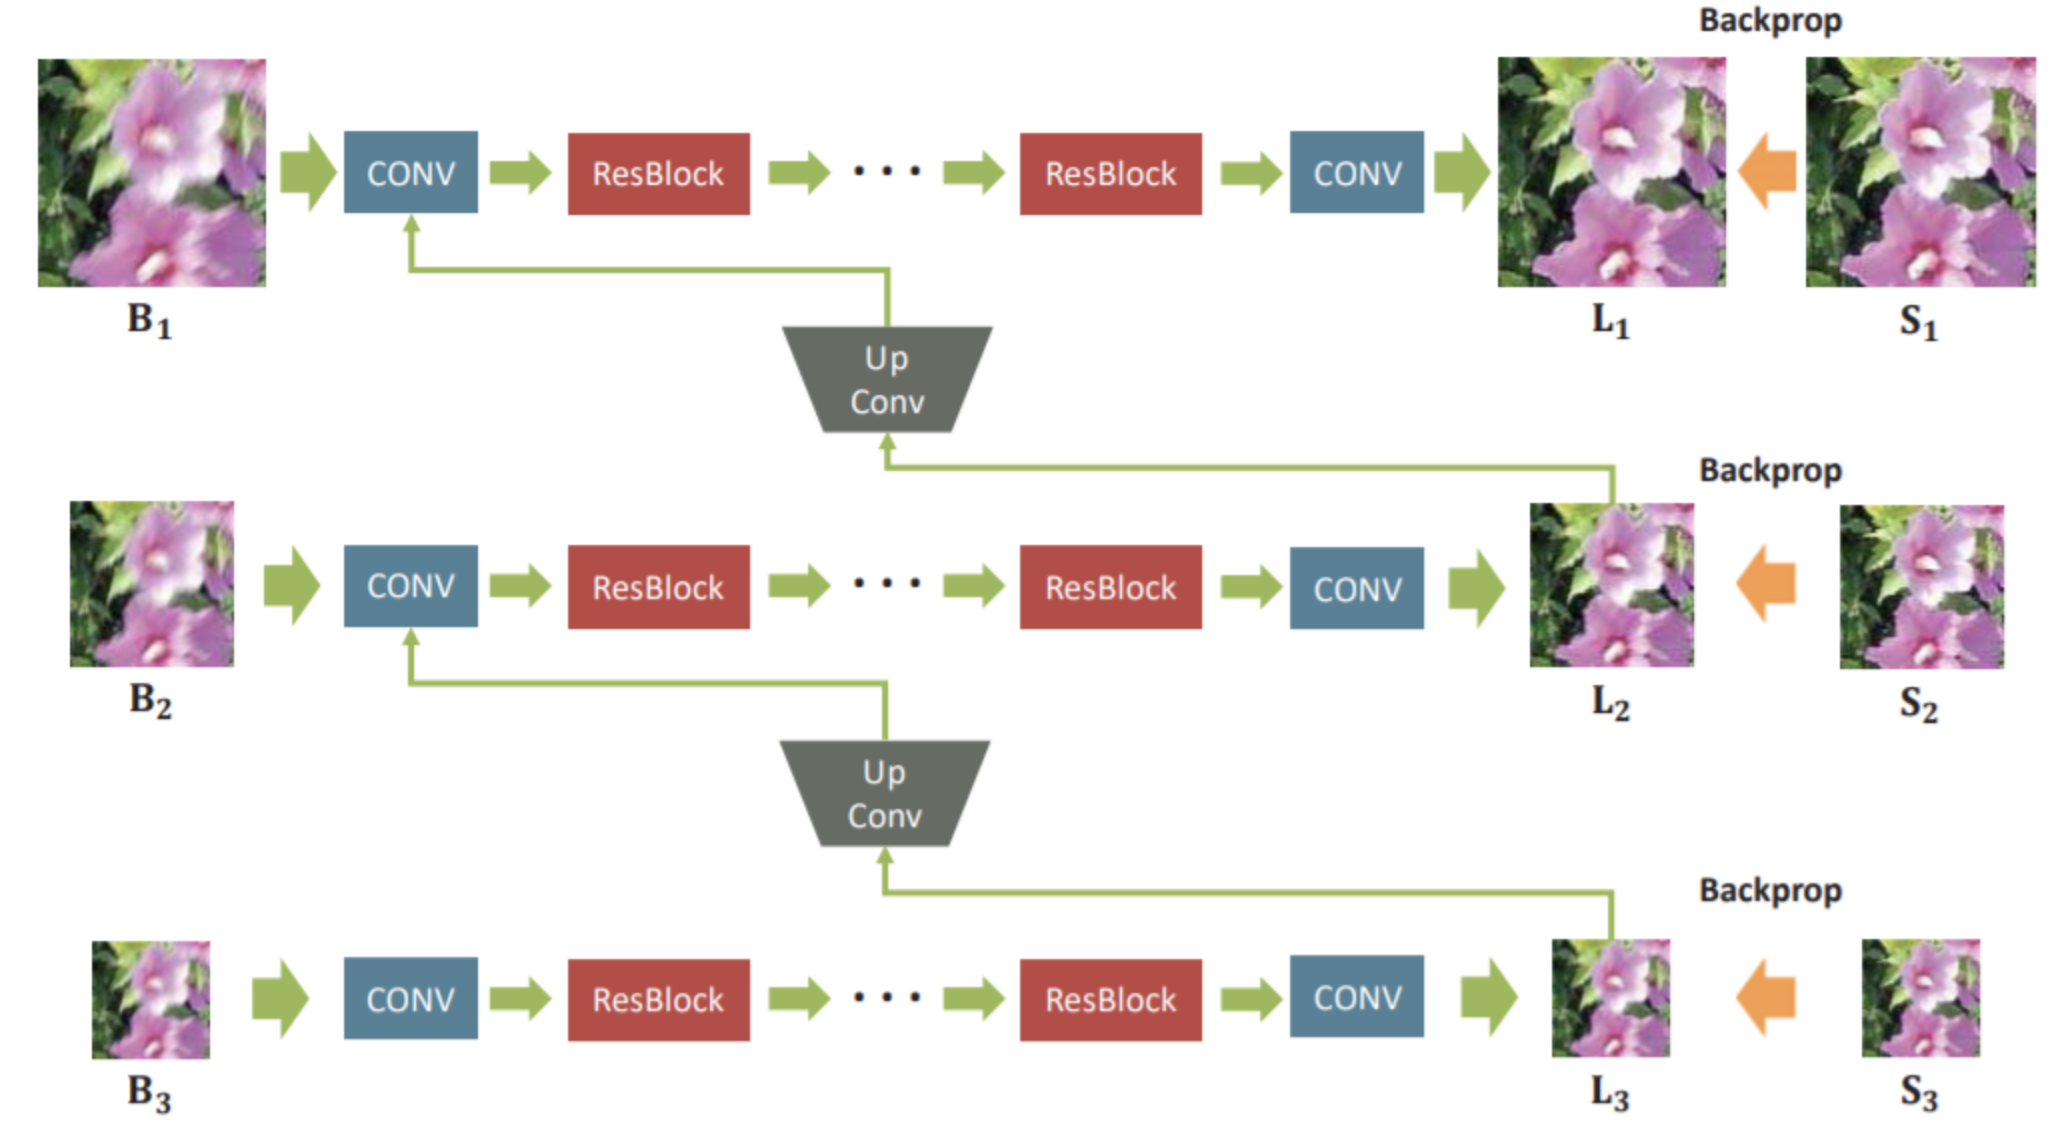

CONV 表示卷积层，
ResBlock 表示残差模块，
Upconv 表示上采样（也可以用反卷积代替）。
从图中可以看出，该模型使用了 “multi-scale” 的结构，
在输入和输出部分都都采用了高斯金字塔（Gaussian pyramid）的形式（即对原图像进行不同尺度的下采样，从而获得处于不同分辨率的图像）

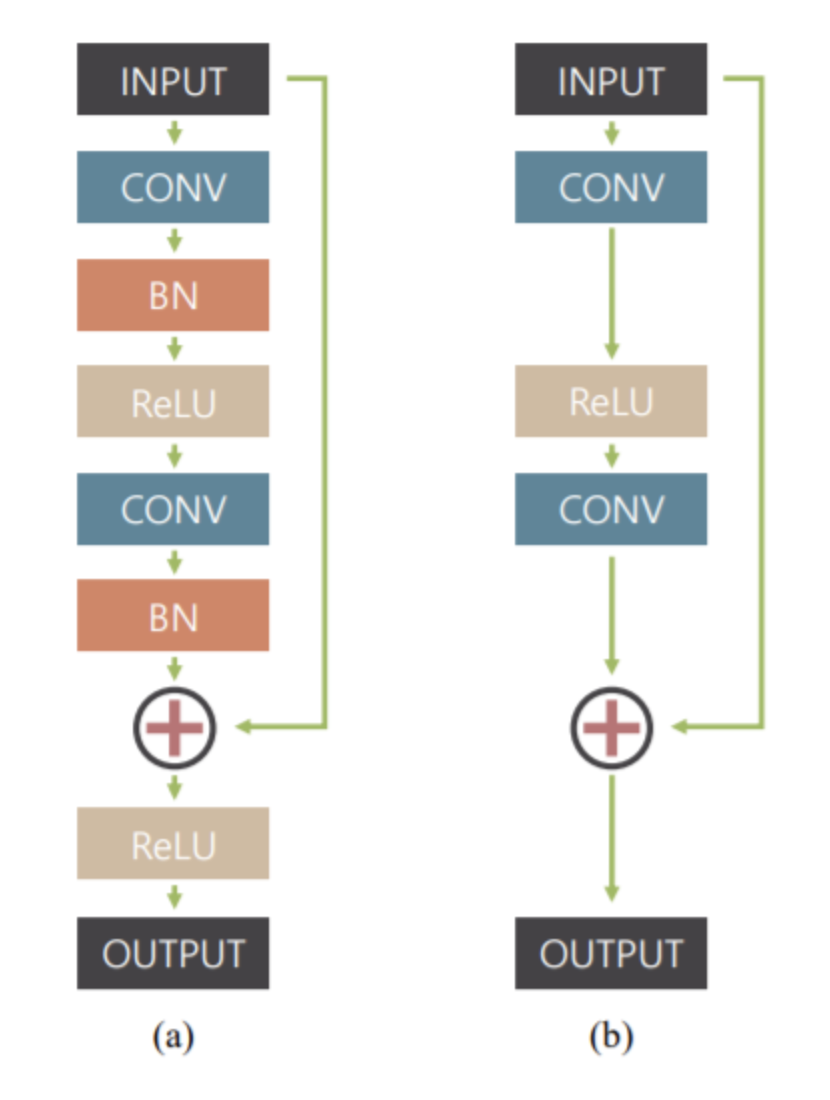

### 模型定义
- default_conv 是模型采用的默认卷积层，
- UpConv 用于上采样卷积，
- ResidualBlock 是模型使用的残差模块，
- SingleScaleNet 是单个尺度网络，
- MultiScaleNet 将几个 SingleScaleNet 整合成了最终的多尺度网络模型

*具体作用*
- default_conv : 网络中默认采用的卷积层，定义之后，避免重复代码
- UpConv : 上卷积，对应上图中的 Up Conv，将图像的尺度扩大，输入到另一个单尺度网络
- ResidualBlock : 残差模块，网络模型中采用的残差模块，之所以采用残差模块，是因为网络“只需要需要模糊图像与去模糊图像之间的差异即可”
- SingleScaleNet : 单尺度模型，一个尺度对应一个单尺度模型实例
- MultiScaleNet : 多尺度模型，将多个单尺度模型实例组合即可得到上图所示的多尺度去模糊网络

In [ ]:
def default_conv(in_channels,out_channels, kernel_size, bias):
    return nn.Conv2d(in_channels,
                    out_channels,
                    kernel_size,
                    padding=(kernel_size // 2),
                    bias=bias)

In [ ]:
class UpConv(nn.Module):
    def __init__(self):
        super(UpConv, self).__init__()
        self.body = nn.Sequential(default_conv(3,12,3,True),
                                 nn.PixelShuffle(2),
                                 nn.ReLU(inplace=True))
        def forward(self,x):
            return self.body(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self,n_feats):
        super(ResidualBlock,self).__init__()
        
        modules_body = [
            default_conv(n_feats, n_feats, 3, bias=True),
            nn.ReLU(inplace=True),
            default_conv(n_feats,n_feats,3,bias=True)
        ]
        
        self.body = nn.Sequential(*modules_body)
        
    def forward(self,x):
        res= self.body(x)
        res += x
        return res

In [ ]:
class SingleScaleNet(nn.Module):
    def __init__(self,n_feats,n_resblocks, is_skip, n_channels=3):
        super(SingleScaleNet, self).__init__()
        self.is_skip = is_skip
        
        modules_head = [
            default_conv(n_channels,n_feats,5,bias=True),
            nn.ReLU(inplace=True)
        ]
        
        modules_body = [ResidualBlock(n_feats) for _ in range(n_resblocks)]
        modules_tail = [default_conv(n_feats, 3,5,bias=True)]
        
        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)
        
    def forward(self,x):
        x= self.head(x)
        res= self.body(x)
        if self.is_skip:
            res += x
        
        res = self.tail(res)
        return res

In [ ]:
class MultiScaleNet(nn.Module):
    def __init__(self,n_feats, n_resblocks ,is_skip):
        super(MultiScaleNet,self).__init__()
        
        self.scale3_net = SingleScaleNet(n_feats,
                                         n_resblocks,
                                         is_skip,
                                         n_channels=3)
        self.upconv3 = UpConv()
        self.scale2_net = SingleScaleNet(n_feats,
                                         n_resblocks,
                                         is_skip,
                                         n_channels=6)
        self.scale2_net = UpConv()
        
        self.scale1_net = SingleScaleNet(n_feats,
                                        n_resblocks,
                                        is_skip,
                                        n_channels=6)
        
    def forward(self,mulscale_input):
        input_b1, input_b2,input_b3 = mulscale_input
        
        output_l3 = self.scale3_net(input_b3)
        output_l3_up = self.upconv3(output_l3)
        
        output_l2 = self.scale2_net(torch.cat((input_b2,output_l3_up),1))
        output_l2_up = self.upconv2(output_l2)
        
        output_l1 = self.scale2_net(torch.cat((input_b1,output_l2_up)),1)
        
        return output_l1,output_l2,output_l3

#### 模型实例化

In [ ]:
if args.multi:
    my_model = MultiScaleNet(n_feats=args.n_feats,
                            n_resblocks = args.n_resblocks,
                            is_skip= args.skip)
else:
    my_model = SingleScaleNet(n_feats=args.n_feats,
                             n_resblocks=args.n_resblocks,
                             is_skip = args.skip)

In [ ]:
# my_model.cuda()
my_model

### 损失函数和优化器

- Adam 优化器，初始学习率为 lr，其相对于 SGD，更自动化，实际中需要调整的参数较少，但需要注意的是，其使用内存也比 SGD 要高。
- 损失函数使用最常见的均方损失函数（MSELoss）:
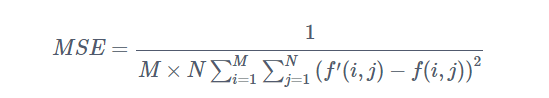
其中 $f^{\prime}(i,j)$ 和 $f(i,j)$ 分别为模型输出结果图和非模糊图上坐标为 $(i,j)$ 的像素，M,N分别表示图片的长与宽。
- 具体的，本文所用的多尺度损失函数为：
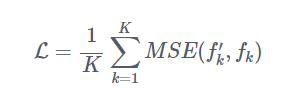
$f^{\prime}_k$ 和 $f_k$分别表示第 $k$ 个尺度上的输出结果图和非模糊图。

In [ ]:
# loss_function = nn.MSELoss().cuda()
loss_function = nn.MSELoss()
optimizer = optim.Adam(my_model.parameters(),lr=args.lr)

### 模型训练
1) 训练策略
2) 训练模型
3) 训练过程可视化

#### 训练策略
- 在模型训练过程中，随着训练的进行，更新网络参数的步进（学习率）应该越来越小，整体训练过程应该满足 “先粗调后细调”，这就是常说的学习率策略。
- 本次训练采用的学习率优化策略为 lr_scheduler.StepLR，步进为 lr_step_size，学习率每隔 lr_step_size 个 epoch 乘以 lr_gamma

In [ ]:
scheduler = lr_scheduler.StepLR(optimizer,args.lr_step_size,args.lr_gamma)

### 训练模型
在训练开始之前，要先创建一个 SummaryWriter，用来记录和可视化训练过程

In [ ]:
writer = SummaryWriter(os.path.join(args.save_dir,"temp/logs/"))

- 在命令行运行 tensorboard --logdir=experiment/logs 来启动tensorboard。
- 在训练模型时，每训练完一个 epoch 将模型的参数保存下来，防止训练被意外中断以及方便测试，如果需要不断更新最新的一次训练的参数，可以取消最后一行的注释。
- 训练过程中，使用 tqdm 的进度条来观察训练过程

In [ ]:
bar_format = '{desc}{percentage:3.0f}% | [{elapsed}<{remaining},{rate_fmt}]' # 进度条格式

for epoch in range(args.epochs):
    total_loss = 0
    batch_bar =  tqdm(data_loader, bar_format=bar_format) # 利用tqdm动态显示训练过程
    for batch,images in enumerate(batch_bar):
        my_model.train()
        curr_batch = epoch * data_loader.__len__() + batch # 当前batch在整个训练过程中的索引

        input_b1 = images['input_b1'] # 原始输入图像
        target_s1 = images['target_s1'] # 目标非模糊图片

        if args.multi:
            input_b2 = images['input_b2']  # level-2 尺度
            target_b2 = images['target_s2']

            input_b3 = images['input_b3']  # level-3 尺度
            target_b3 = images['target_s3']
            output_l1, output_l2, output_l3 = my_model((input_b1,input_b2,input_b3))

            # 损失函数
            loss = (loss_function(output_l1,target_s1) + loss_function(output_l2,target_b2) + loss_function(output_l3, target_b3)) /3 

        else:
            output_l1 = my_model(input_b1)
            loss = loss_function(output_l1,target_s1)

        my_model.zero_grad()
        loss.backward()  #反向传播
        optimizer.step() # 更新权值
        total_loss += loss.item()


        print_str = "|".join([
            "epoch:%3d/%3d" % (epoch + 1, args.epochs),
            "batch:%3d/%3d" % (batch + 1, data_loader.__len__()),
            "loss:%.5f" % (loss.item()),
        ])
        batch_bar.set_description(print_str,refresh=True)  # 更新进度条

        writer.add_scalar('train/batch_loss', loss.item(), curr_batch)

    batch_bar.close()
    scheduler.step() #调整学习率
    loss = total_loss / (batch +1)

    writer.add_scalar('train/batch_loss',loss,epoch)
    torch.save(my_model.state_dict(),os.path.join(args.save_cp_dir, f'Epoch_{epoch}.pt')) # 保存每个 epoch 的参数
#     torch.save(my_model.state_dict(),os.path.join(args.save_cp_dir, f'Epoch_lastest.pt')) # 保存最新的参数

In [ ]:
!pip install xeus-python -i https://pypi.tuna.tsinghua.edu.cn/simple